In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('AER_credit_card_data.csv')

In [4]:
df['card'] = df['card'].map({'yes': 1, 'no': 0})

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
df_test.shape[0], df_train.shape[0], df_val.shape[0]

(264, 791, 264)

In [7]:
for col in ['reports', 'age', 'income', 'share', 'expenditure',
            'dependents', 'months', 'majorcards', 'active']:
    print(col, roc_auc_score(df_train['card'], df_train[col]))

reports 0.28333701393106236
age 0.4759979020592945
income 0.5908049467233478
share 0.989183643423692
expenditure 0.991042345276873
dependents 0.46722427722262094
months 0.470578221903237
majorcards 0.5343859842838476
active 0.6043173411362006


In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [9]:
numerical = ["reports", "age", "income", "share", "expenditure",
             "dependents", "months", "majorcards", "active"]

categorical = ["owner", "selfemp"]

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [10]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [11]:
val_dict = df_val[categorical + numerical].to_dict('records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val,)[:, 1]

In [12]:
round(roc_auc_score(y_val, y_pred), 3)

0.995

In [13]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [14]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

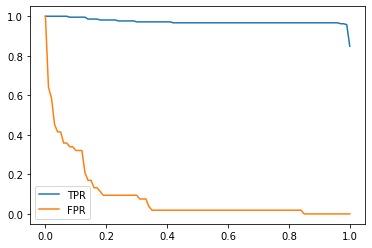

In [15]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()


In [16]:
df_scores['p'] = df_scores['tp']/(df_scores['tp']+df_scores['fp'])
df_scores['r'] = df_scores['tp']/(df_scores['tp']+df_scores['fn'])

In [17]:
df_scores['F1'] = 2* df_scores['p']*df_scores['r']/(df_scores['p']+df_scores['r'])

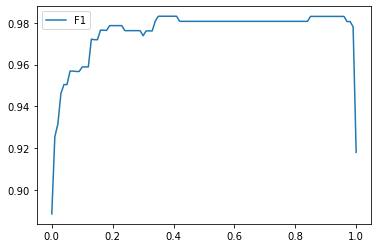

In [18]:
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')
plt.legend()

In [23]:
df_scores.sort_values(by='F1').tail()

,threshold,tp,fp,fn,tn,tpr,fpr,p,r,F1
38,0.38,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
35,0.35,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213


In [19]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)


In [20]:
round(np.std(scores), 3)

0.003

In [78]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

C=0.01 0.995 +- 0.004


 50%|█████     | 2/4 [00:00<00:00,  3.40it/s]

C=0.1 0.997 +- 0.003


 75%|███████▌  | 3/4 [00:01<00:00,  2.79it/s]

C=1 0.996 +- 0.003


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

C=10 0.997 +- 0.003
